In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import re
import datetime
import math
import random
from ast import literal_eval
from dateutil.parser import parse
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split 
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [2]:
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
random.seed(0)

In [4]:
def convert_seconds(x):
    try:
        return (datetime.datetime.combine(x, datetime.datetime.min.time())-
                datetime.datetime(1970,1,1)).total_seconds()
    except Exception as e:
        return x

In [5]:
def literal_return(val):
    try:
        return literal_eval(val)
    except (ValueError, SyntaxError) as e:
        return val

In [6]:
def match_not_data(data):
    try:
        if list(data.keys())[0] == 'Not enough data.':
            return np.nan
        else:
            return data
    except Exception as e:
        return data

In [7]:
def changeWord(word):
    for letter in word:
        if letter == "-" or letter == "/" or letter == "'" or letter == "." or letter == "&" or letter == "+":
            word = word.replace(letter,"_")
    return word

In [8]:
def get_mainStory (dict):
    if "Main Story" in dict.keys():
        return dict["Main Story"][1]/3600

In [9]:
def get_mainStoryFormatted (data_list):
    try:
        return data_list[1]
    except Exception as e:
        return data_list

In [10]:
def get_storyAnalisisFormatted (data_list):
    try:
        return data_list/3600
    except Exception as e:
        return data_list

In [11]:
data = pd.read_csv("data_file.csv", header = 0)

In [12]:
data.columns

Index(['name', 'description', 'Playable On', 'Genres', 'NA', 'EU', 'JP',
       'Additional Content', 'Single-Player', 'Speedrun', 'Retirement',
       'Platform', 'Type', 'Main Game', 'Multi-Player', 'Rating', 'Platform N',
       'Publishers', 'Developers'],
      dtype='object')

In [13]:
pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=False)

data.head()

,name,description,Playable On,Genres,NA,EU,JP,Additional Content,Single-Player,Speedrun,Retirement,Platform,Type,Main Game,Multi-Player,Rating,Platform N,Publishers,Developers
0,Bomberman: Panic Bomber,Bomberman's hunt for the Golden Bomber statue.,NaN,"['Third-Person', 'Real-Time', 'Puzzle']",NaN,NaN,"December 22, 1994",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hudson Soft,Hudson Soft
1,RIP (2014),NaN,NaN,"['First-Person', 'Shooter']","October 31, 2014",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Axyos Games,Axyos Games
2,Mr. Postman,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'Not enough data.': ['', '', '', '', '', '']}",NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Capsule,Capsule is a single-player survival game playe...,['PC'],NaN,"February 04, 2012",NaN,NaN,NaN,"{'Main Story': ['4', '1h 41m', '1h 40m', '1h 3...",NaN,5.94,"{'PC': ['10', '1h 41m', '3h', '2h 29m', '1h 22...",NaN,NaN,NaN,47.0,{'PC': '23'},Finji,NaN
4,Spectrum 2000,NaN,NaN,"['Scrolling', 'Shooter']",2000,NaN,NaN,NaN,"{'Main + Extras': ['1', '28m', '28m', '28m', '...",NaN,NaN,"{'Not enough data.': ['', '', '', '', '', '']}",NaN,NaN,NaN,NaN,NaN,NaN,NaN


Se revisan los NA por variable

In [14]:
pd.DataFrame([data.isna().sum(), (data.shape[0] - data.isna().sum()), (data.isna().sum()/data.shape[0])*100], index=['isna','total-isna','% na'])

,name,description,Playable On,Genres,NA,EU,JP,Additional Content,Single-Player,Speedrun,Retirement,Platform,Type,Main Game,Multi-Player,Rating,Platform N,Publishers,Developers
isna,0.0,32522.000000,45122.000000,32973.000000,32265.000000,50646.000000,63845.000000,69683.000000,44447.000000,68051.00000,50881.000000,31516.0000,68786.000000,68869.00000,68328.000000,50881.000000,48162.000000,34097.00000,32563.000000
total-isna,70322.0,37800.000000,25200.000000,37349.000000,38057.000000,19676.000000,6477.000000,639.000000,25875.000000,2271.00000,19441.000000,38806.0000,1536.000000,1453.00000,1994.000000,19441.000000,22160.000000,36225.00000,37759.000000
% na,0.0,46.247263,64.164842,46.888598,45.881801,72.020136,90.789511,99.091323,63.204971,96.77057,72.354313,44.8167,97.815762,97.93379,97.164472,72.354313,68.487813,48.48696,46.305566


In [15]:
dataAux = data.copy()    

# Data structure detection and transformation

Convert a string into a dictionary for the Genres, Single-Player, Platform, Platform N and Main Game

In [16]:
dataAux["Genres"] = dataAux["Genres"].apply(lambda x: literal_return(x) if not pd.isna(x) else x)
dataAux["Single-Player"] = dataAux["Single-Player"].apply(lambda x: literal_return(x) if not pd.isna(x) else x)
dataAux["Platform"] = dataAux["Platform"].apply(lambda x: literal_return(x) if not pd.isna(x) else x)
dataAux["Platform N"] = dataAux["Platform N"].apply(lambda x: literal_return(x) if not pd.isna(x) else x)
dataAux["Main Game"] = dataAux["Main Game"].apply(lambda x: literal_return(x) if not pd.isna(x) else x)

# Platform deleting rows without information

Delete dictionaries from Platform that contains not enough data description

In [17]:
dataAux["Platform"] = dataAux["Platform"].apply(lambda x: match_not_data(x)).fillna(value=np.nan)

# Rating and Single Player rows dropping

Because the main objective are the Rating, Single-Player and Platform, if at least one of them is NaN, it's deleted

In [18]:
indexNames = dataAux[dataAux['Rating'].isna()].index
dataAux.drop(indexNames , inplace=True)

In [19]:
indexNames = dataAux[dataAux['Single-Player'].isna() & dataAux["Platform"].isna()].index
dataAux.drop(indexNames , inplace=True)

In [20]:
dataAux.shape

(16735, 19)

In [21]:
pd.DataFrame([dataAux.isna().sum(), (dataAux.notna().sum())], index=['isna','total-isna'])

,name,description,Playable On,Genres,NA,EU,JP,Additional Content,Single-Player,Speedrun,Retirement,Platform,Type,Main Game,Multi-Player,Rating,Platform N,Publishers,Developers
isna,0,965,725,1012,959,9013,13102,16150,0,14651,0,836,16044,16050,15201,0,836,2659,2408
total-isna,16735,15770,16010,15723,15776,7722,3633,585,16735,2084,16735,15899,691,685,1534,16735,15899,14076,14327


# Date and hour parsing and transformation

**Elementos del array de Single Player**

Polled(Siempre un numero)	Average(Horas minutos)	Median(Horas minutos)	Rushed(Horas minutos)	Leisure(Horas minutos)

Estos numeros reflejan los resultados obtenidos para la cateogria listada en el diccionario.

Se reconvierten a segundos todos menos el primero.

In [22]:
def convert_text_to_number(dicts):
    if type(dicts) == dict:
        for key, value in dicts.items():
            try:
                for count, item in enumerate(value):
                    #print(count, type(item))
                    try:
                        if type(item) is int:
                            value[count] =  int(item) #si es un número se mantiene como tal
                        elif type(item) is str:
                            seconds = 0
                            for time in item.split(" "):
                                if(time[-1] == "h"):
                                    seconds += int(time[:-1]) * 3600
                                elif(time[-1] == "m"):
                                    seconds += int(time[:-1]) * 60                            
                            value[count] = seconds
                            dicts[key] = value
                            
                    except Exception as e:
                        pass
            except Exception as e:
                pass
    return dicts 
    

dataAux["Single-Player"] = dataAux["Single-Player"].apply(lambda x: convert_text_to_number(x))


In [23]:
def parse_game_dates(dateStr):
    date = None
    try:
        dateAux = parse(dateStr)
        return dateAux.date()
        #date = pd.to_datetime(dateStr), format="%B %d, %Y")
    except Exception as e:
        return dateStr

        
dataAux["NA"] = dataAux["NA"].apply(lambda x: parse_game_dates(x))
dataAux["EU"] = dataAux["EU"].apply(lambda x: parse_game_dates(x))
dataAux["JP"] = dataAux["JP"].apply(lambda x: parse_game_dates(x))
aux = parse('1988')
print(aux.date())

1988-10-18


In [24]:
dataAux["NA"] = dataAux["NA"].apply(lambda x: convert_seconds(x))
dataAux["JP"] = dataAux["JP"].apply(lambda x: convert_seconds(x))
dataAux["EU"] = dataAux["EU"].apply(lambda x: convert_seconds(x))
dataAux.head()

,name,description,Playable On,Genres,NA,EU,JP,Additional Content,Single-Player,Speedrun,Retirement,Platform,Type,Main Game,Multi-Player,Rating,Platform N,Publishers,Developers
3,Capsule,Capsule is a single-player survival game playe...,['PC'],NaN,1.328314e+09,NaN,NaN,NaN,"{'Main Story': [0, 6060, 6000, 5520, 6600], 'M...",NaN,5.94,"{'PC': ['10', '1h 41m', '3h', '2h 29m', '1h 22...",NaN,NaN,NaN,47.0,{'PC': '23'},Finji,NaN
7,Fantasy Zone II: The Tears of Opa-Opa,NaN,"['Nintendo 3DS', 'Sega Master System']","[Scrolling, Shooter]",5.667840e+08,5.931360e+08,NaN,NaN,"{'Main Story': [0, 5160, 5400, 3540, 7020], 'A...",NaN,6.90,"{'Nintendo 3DS': ['3', '1h 48m', '--', '--', '...",NaN,NaN,NaN,70.0,"{'Nintendo 3DS': '4', 'Sega Master System': '7'}",NaN,NaN
11,Siege of Avalon,Siege of Avalon is a traditional fantasy-RPG w...,['PC'],"[Top-Down, Real-Time, Action, Role-Playing]",9.567936e+08,NaN,NaN,NaN,"{'Main + Extras': [0, 81060, 93600, 60900, 101...",NaN,11.11,"{'PC': ['3', '--', '22h 31m', '--', '9h 34m', ...",NaN,NaN,NaN,40.0,{'PC': '4'},NaN,Digital Tome
16,Codename: Outbreak,"In the early 21st century, a meteor storm hits...",['PC'],"[First-Person, Shooter]",1.006646e+09,NaN,NaN,NaN,"{'Main Story': [0, 21540, 21540, 17940, 25080]...",NaN,15.38,"{'PC': ['2', '5h 59m', '--', '--', '4h', '7h 5...",NaN,NaN,NaN,60.0,{'PC': '4'},Virgin Interactive,GSC Game World
22,A Bird Story,"From the creator of To the Moon: A simple, wor...",['PC'],Adventure,1.415318e+09,1.415318e+09,NaN,NaN,"{'Main Story': [0, 4620, 4320, 3120, 7620], 'M...",NaN,2.16,"{'PC': ['612', '1h 17m', '1h 27m', '1h 27m', '...",NaN,NaN,NaN,68.0,{'PC': '1.5K'},Freebird Games,Freebird Games


# Number transformation

Convert each number from Platform N, and Platform from a string into a number

In [25]:
def convert_platform_to_thousands(dicts):
    if type(dicts) == dict:
        for key, value in dicts.items():
            try:
                if value.isdigit():
                    dicts[key] =  int(value)
                else:
                    value = int(float(value.strip( 'K' ))*1000)
                    dicts[key] = value
            except Exception as e:
                pass
    return dicts 
    

dataAux["Platform N"] = dataAux["Platform N"].apply(lambda x: convert_platform_to_thousands(x))
dataAux["Platform"] = dataAux["Platform"].apply(lambda x: convert_text_to_number(x))

# Wide formatting

Se despivotan las columnas Single-Player

In [26]:
dataAns1 = dataAux.copy()

spType = ["SP_MainStory", "SP_Main+Extras", "SP_Completionists", "SP_AllPlayStyles"]

In [27]:
#Despivote de Additional Content
def despivotar_col(col_name, namePrefix, data):
    #Se obtienen los elementos (keys) de los diccionarios de Single player
    elements = []
    for game in data[col_name]:
            for element in game.keys():
                if element not in elements:
                    elements.append(element)

    print(elements)


    def get_element_from_game(x, element):
        #Dado un elemento del diccionario de "Single player" retorna sus datos
        if type(x) is dict:
            if element in x.keys():
                return x[element]

    #Para cada elemento se añade una columna nueva con SP al principio para idicar que es single player
    for element in elements:
        #element = ''.join(element.split())
        data[(namePrefix + element)] = data[col_name].apply(lambda x: get_element_from_game(x,element))
        nameCol = namePrefix + element
        renameCol = ''.join(nameCol.split())
        data = data.rename(columns={nameCol: renameCol})


    #Se elimina la columna original
    data.drop([col_name], axis='columns', inplace=True)  
    return data

dataAux = despivotar_col("Single-Player", "SP_", dataAux)


for sp in spType:

    dataAux[sp] =  dataAux[sp].apply(lambda x: get_mainStoryFormatted(x))


['Main Story', 'Main + Extras', 'Completionists', 'All PlayStyles']


Ahora se despivota la columna Platform N

In [28]:
#Se despivota Platform n
elements = []
def despivotar_col(col_name, namePrefix, data):
    #Se obtienen los elementos (keys) de los diccionarios de Single player
    for game in data[col_name]:
        if not (type(game) is float):
            for element in game.keys():
                if element not in elements:
                    elements.append(element)

    #print(elements)


    def get_element_from_game(x, element):
        #Dado un elemento del diccionario de "Single player" retorna sus datos
        if type(x) is dict:
            if element in x.keys():
                return x[element]

    #Para cada elemento se añade una columna nueva con SP al principio para idicar que es single player
    for count,element in enumerate(elements):
        data[(namePrefix + element)] = data[col_name].apply(lambda x: get_element_from_game(x,element))
        nameCol = namePrefix + element
        renameCol = changeWord(''.join(nameCol.split()))
        data = data.rename(columns={nameCol: renameCol})
        elements[count] = changeWord(''.join(element.split()))


    #Se elimina la columna original
    data.drop([col_name], axis='columns', inplace=True)  
    return data
    
dataAux = despivotar_col("Platform N","N_", dataAux)
games = elements

In [29]:
for game in games:
    dataAux["N_" + game] = dataAux["N_" + game].fillna(0)

In [30]:
gameNTotal = []
for game in games:
    gameNTotal.append(dataAux["N_" + game].sum())

In [31]:
np.mean(gameNTotal)

41252.42622950819

**Despivotar la columna de Generos**

In [32]:
genres = []

#Se obtienen los elementos (keys) de los diccionarios de Single player
for game in dataAux["Genres"]:
    if not (type(game) is float):
        if type(game) is list:
            for element in game:
                if element not in genres:
                    genres.append(element)
            else:
                if element not in genres:
                    genres.append(element)

#print(genres)
def check (x, element):
    if type(x) is float:
        pass
    else:
        if type(x) is list:
            if element in x:
                return 1
            else:
                return 0
        else:
            if x == element:
                return 1
            else:
                return 0
#Para cada elemento se añade una columna nueva con SP al principio para idicar que es single player
for element in genres:
    dataAux[("G_" + element)] = dataAux["Genres"].apply(lambda x: check(x, element))
    nameCol = "G_" + element
    renameCol = changeWord(''.join(nameCol.split()))
    dataAux = dataAux.rename(columns={nameCol: renameCol})

    
print("done")

done


In [33]:
dataAux = dataAux.drop(columns=['Additional Content', 'Speedrun',
                                            'name', 'description', 'Playable On', 
                                            'Genres', 'Platform', 'Multi-Player', 'Main Game'])
dataAux.head()

,NA,EU,JP,Retirement,Type,Rating,Publishers,Developers,SP_MainStory,SP_Main+Extras,SP_Completionists,SP_AllPlayStyles,N_PC,N_Nintendo3DS,N_SegaMasterSystem,N_PlayStation3,N_PlayStation4,N_Xbox360,N_NintendoSwitch,N_XboxOne,N_NES,N_PlayStationVita,N_PlayStation,N_Mobile,N_WiiU,N_GameBoyAdvance,N_ZXSpectrum,N_Arcade,N_SegaMegaDrive_Genesis,N_PlayStation2,N_NintendoDS,N_PSP,N_NintendoGameCube,N_SegaSaturn,N_Wii,N_Amiga,N_GameBoyColor,N_Emulated,N_NECPC_9801_21,N_Nintendo64,N_SuperNintendo,N_GoogleStadia,N_Atari2600,N_PlayStationVR,N_Browser,N_Xbox,N_GameBoy,N_N_Gage,N_VirtualBoy,N_PCVR,N_PlayStationNow,N_OculusQuest,N_Dreamcast,N_SegaCD,N_AppleII,N_TurboGrafx_16,N_AtariJaguar,N_NeoGeo,N_OnLive,N_SegaGameGear,N_AtariLynx,N_TurboGrafx_CD,N_Commodore64,N_NeoGeoPocket,N_Atari5200,N_Sega32X,N_WonderSwan,N_Atari7800,N_Game_Watch,N_3DO,N_Ouya,N_MSX,N_NeoGeoCD,G_Scrolling,G_Shooter,G_Top_Down,G_Real_Time,G_Action,G_Role_Playing,G_First_Person,G_Adventure,G_Puzzle,G_Strategy,G_Multidirectional,G_Platform,G_SurvivalHorror,G_Point_and_Click,G_Compilation,G_Tactical,G_Arcade,G_Racing_Driving,G_Turn_Based,G_Text,G_Fighting,G_Pinball,G_Horror,G_Survival,G_Third_Person,G_HiddenObject,G_MassivelyMultiplayer,G_Racing,G_Simulation,G_Stealth,G_Sports,G_BoardGame,G_TowerDefense,G_Beat_emUp,G_HackandSlash,G_On_Rails,G_VisualNovel,G_City_Building,G_Roguelike,G_InteractiveArt,G_OpenWorld,G_Party,G_CarCombat,G_Sandbox,G_VirtualReality,G_Side,G_VehicularCombat,G_BattleArena,G_Music_Rhythm,G_Educational,G_FlightCombat,G_CardGame,G_Flight,G_Fitness,G_Strategy_Tactical,G_Isometric,G_Platformer,G_role_playing,G_CombatFlightSimulator,G_Third_person,G_action_adventure,G_side_scroller,G_Side_scroller,G_Shoot_emup,G_Flightsimulator,G_Shoot_em_up,G_Top_down,G_3_D,G_Survivalhorror,G_actionadventure,G_action,G_adventure,G_City_building,G_Real_timeStrategy,G_Light_GunShooter,G_Third_personshooter,G_MechaSimulation,G_Side_Scroller,G_Shoot_emUp,G_Beat_emup,G_RPG,G_Graphicadventure,G_Point_and_clickadventure,G_Role_playinggame,G_Action_adventuregame,G_Stealthgame,G_Beat,G_Real_timetactics,G_platformer,G_Casual,G_Indie,G_hackandslash,G_educational,G_Music,G_post_retro,G_Scrollingshooter,G_music,G_Various,G_Fightinggame,G_Visualnovel,G_Americanfootball,G_Hackandslash,G_Vehicularcombat,G_puzzle,G_First_person,G_Tacticalshooter,G_Family,G_first_personshooter,G_Action_adventure,G_platforming,G_ActionRPG,G_Adventuregame,G_Third_personShooter,G_Mini_Games,G_FMV,G_FamilyGames,G_Sidescrolling,G_platform,G_Rhythm,G_Exercise,G_Third_personhackandslash,G_Firstperson,G_Sport,G_minigames,G_First_personshooter,G_survivalhorror,G_Real_TimeStrategy,G_DungeonCrawl,G_Role_playing,G_digitalpet,G_Dramatic_InnovativeRPG,G_third_personshooter,G_Real_timeTactics,G_interactivemovie,G_roleplaying,G_Aerialcombat,G_Driving,G_Third_PersonShooter,G_Sciencefiction,G_Real_timestrategy,G_Godgame,G_Computerrole_playinggame,G_Tacticalaction,G_Cardbattle,G_turn_basedstrategy,G_turn_basedtactics,G_Hack_and_slash,G_Runandgun,G_Simulator,G_Tacticalrole_playinggame,G_sandbox,G_CombatSimulation,G_Tactics,G_Real_timetacticalshooter,G_strategyside_scroller,G_Hack_n_Slash,G_MedievalFantasyAction,G_Shooting,G_flightsimulator,G_RTS,G_Socialsimulation,G_Puzzlegame,G_City_Builder,G_Spacesimulation,G_Golf,G_shooter,G_First_personShooter,G_DungeonCrawler,G_dungeoncrawl,G_Side_scrollingplatform,G_shoot_emup,G_graphicadventure,G_3DPlatform,G_Platforming,G_railshooter,G_Sportsgame,G_Turn_BasedStrategy,G_Wrestling,G_Side_scrolling,G_Moba,G_Turn_basedstrategy,G_CardBattle,G_Psychologicalhorror,G_Mecha,G_strategy,G_Stealth_basedgame,G_collectiblecardgame,G_turn_basedtactical,G_Stealthaction,G_Mechasimulationgame,G_runandgun,G_arcade,G_Crossover,G_Beat_emup,G_Platformgame,G_Computerrole_playing,G_First_PersonShooter,G_ActionAdventure,G_StrategyRPG,G_TacticalShooter,G_Openworld,G_Maze,G_Actionrole_playing,G_Rhythmgame,G_stealth,G_Interactivemovie,G_Spacesimulator,G_TBS,G_Third_personactionadventure,G_Western,G_Firstpersonshoo

# Agrupation of values and dummies

In [34]:
developers_count = dataAux.groupby(by=["Developers"])["Developers"].count().sort_values()
developers_limit_list = developers_count.index[np.where(developers_count < 20)]

dataAux["Developers"] = dataAux["Developers"].replace(developers_limit_list, "OtherDevelopers")

In [35]:
publishers_count = dataAux.groupby(by=["Publishers"])["Publishers"].count().sort_values()
publishers_limit_list = publishers_count.index[np.where(publishers_count < 20)]

dataAux["Publishers"] = dataAux["Publishers"].replace(publishers_limit_list, "OtherPublishers")

# Deleting duplicated columns

In [36]:
dataAux = dataAux.drop(columns=dataAux.columns[dataAux.columns.duplicated()])

In [37]:
def get_outliers_and_no_outliers(dataAux, spType):
    
    dataAux_outliers = dataAux.copy()

    for sp in spType:
        q25, q75 = np.nanpercentile(dataAux[sp], 25), np.nanpercentile(dataAux[sp], 75)
        iqr = q75 - q25
        cut_off = iqr * 1.5
        lower, upper = q25 - cut_off, q75 + cut_off
        outliers = [index  for index, row in dataAux.iterrows() if row[sp] < lower or row[sp] > upper]
        dataAux = dataAux.drop(outliers)
        
    for sp in spType:
        q25, q75 = np.nanpercentile(dataAux_outliers[sp], 25), np.nanpercentile(dataAux_outliers[sp], 75)
        iqr = q75 - q25
        cut_off = iqr * 1.5
        lower, upper = q25 - cut_off, q75 + cut_off
        
        no_outliers = [index for index, row in dataAux_outliers.iterrows() if row[sp] >= lower or row[sp] <= upper]        
        dataAux_outliers = dataAux_outliers.drop(no_outliers)            
    return dataAux, dataAux_outliers

In [38]:
dataAns2 = dataAux.copy()

spType = ["SP_MainStory", "SP_Main+Extras", "SP_Completionists", "SP_AllPlayStyles"]
dataAns2, dataAns2_outliers = get_outliers_and_no_outliers(dataAns2, spType)

dataAux = pd.get_dummies(dataAux, columns=['Type', 'Publishers', 'Developers'])

/home/agorgues/miniconda3/envs/tfm/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/agorgues/miniconda3/envs/tfm/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# Columns renaming

In [39]:
def renaming_fun(x):
    renameCol = changeWord(''.join(x.split()))
    return renameCol

dataAux = dataAux.rename(columns=renaming_fun)

# Outliers detection

In [40]:
spType = ["SP_MainStory", "SP_Main_Extras", "SP_Completionists", "SP_AllPlayStyles"]

dataAux, dataAux_outliers = get_outliers_and_no_outliers(dataAux, spType)

# Correlation Rating vs all SP

In [41]:
rating = dataAux["Rating"]
spType = ["SP_MainStory", "SP_Main_Extras", "SP_Completionists", "SP_AllPlayStyles"]
for sp in spType:

    spTime = dataAux[sp].apply(lambda x: get_mainStoryFormatted(x))
    gamesData = {sp: spTime,
        'Rating': rating
        }
    df = pd.DataFrame(gamesData)
    
    print(df.corr())

              SP_MainStory    Rating
SP_MainStory      1.000000  0.274443
Rating            0.274443  1.000000
                SP_Main_Extras    Rating
SP_Main_Extras        1.000000  0.270119
Rating                0.270119  1.000000
                   SP_Completionists    Rating
SP_Completionists           1.000000  0.329177
Rating                      0.329177  1.000000
                  SP_AllPlayStyles    Rating
SP_AllPlayStyles          1.000000  0.295488
Rating                    0.295488  1.000000


# VIF

In [42]:
#features = list(data_vif.columns)
#features.remove('Rating')
#features = "+".join(features)


In [43]:
# get y and X dataframes based on this regression:
#y, X = dmatrices('Rating ~' + features, data_vif, return_type='dataframe')
#X.values
#vif = pd.DataFrame()
#vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
#vif["features"] = X.columns
#vif.round(1)

data_vif = dataAux.copy()


repeat =True

while repeat:
    features = list(data_vif.columns)
    features.remove('Rating')
    features = "+".join(features)
    
    # get y and X dataframes based on this regression:
    y, X = dmatrices('Rating ~' + features, data_vif, return_type='dataframe')
    #X.values
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns
    
    vif_sna = vif.dropna()
    vif_sna = vif_sna.drop([0])
 
    vif_max_values = vif_sna[vif_sna["VIF Factor"]> 5]
    if len(vif_max_values) > 0:
        vif_max_column = vif_sna.loc[vif_sna['VIF Factor'].idxmax()]["features"]
        data_vif = data_vif.drop(columns = [vif_max_column])
    
    else:
        repeat = False
        

features = list(data_vif.columns)
features.remove('Rating')
features = "+".join(features)
y, X = dmatrices('Rating ~' + features, data_vif, return_type='dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.round(1)

# VIF config 

In [44]:
vif_table = pd.read_csv('vif_table.csv', sep=',')
vif_table.drop(vif_table[vif_table.features == "Intercept"].index, inplace = True)

In [45]:
def get_string_from_match(x, regex_match):
    try:
        return regex_match.search(x).string
    except Exception as e:
        return None

In [46]:
r_genres = re.compile('^G_.*')
findGenCols = np.vectorize(lambda x:get_string_from_match(x,r_genres))
match_genres = findGenCols(dataAux.columns.values)
match_genres = match_genres[match_genres != np.array(None)]

for i in match_genres:
    dataAux[i] = dataAux[i].fillna(0)

In [47]:
pd.DataFrame([dataAux.isna().sum(), (dataAux.notna().sum())], index=['isna','total-isna'])

,NA,EU,JP,Retirement,Rating,SP_MainStory,SP_Main_Extras,SP_Completionists,SP_AllPlayStyles,N_PC,N_Nintendo3DS,N_SegaMasterSystem,N_PlayStation3,N_PlayStation4,N_Xbox360,N_NintendoSwitch,N_XboxOne,N_NES,N_PlayStationVita,N_PlayStation,N_Mobile,N_WiiU,N_GameBoyAdvance,N_ZXSpectrum,N_Arcade,N_SegaMegaDrive_Genesis,N_PlayStation2,N_NintendoDS,N_PSP,N_NintendoGameCube,N_SegaSaturn,N_Wii,N_Amiga,N_GameBoyColor,N_Emulated,N_NECPC_9801_21,N_Nintendo64,N_SuperNintendo,N_GoogleStadia,N_Atari2600,N_PlayStationVR,N_Browser,N_Xbox,N_GameBoy,N_N_Gage,N_VirtualBoy,N_PCVR,N_PlayStationNow,N_OculusQuest,N_Dreamcast,N_SegaCD,N_AppleII,N_TurboGrafx_16,N_AtariJaguar,N_NeoGeo,N_OnLive,N_SegaGameGear,N_AtariLynx,N_TurboGrafx_CD,N_Commodore64,N_NeoGeoPocket,N_Atari5200,N_Sega32X,N_WonderSwan,N_Atari7800,N_Game_Watch,N_3DO,N_Ouya,N_MSX,N_NeoGeoCD,G_Scrolling,G_Shooter,G_Top_Down,G_Real_Time,G_Action,G_Role_Playing,G_First_Person,G_Adventure,G_Puzzle,G_Strategy,G_Multidirectional,G_Platform,G_SurvivalHorror,G_Point_and_Click,G_Compilation,G_Tactical,G_Arcade,G_Racing_Driving,G_Turn_Based,G_Text,G_Fighting,G_Pinball,G_Horror,G_Survival,G_Third_Person,G_HiddenObject,G_MassivelyMultiplayer,G_Racing,G_Simulation,G_Stealth,G_Sports,G_BoardGame,G_TowerDefense,G_Beat_emUp,G_HackandSlash,G_On_Rails,G_VisualNovel,G_City_Building,G_Roguelike,G_InteractiveArt,G_OpenWorld,G_Party,G_CarCombat,G_Sandbox,G_VirtualReality,G_Side,G_VehicularCombat,G_BattleArena,G_Music_Rhythm,G_Educational,G_FlightCombat,G_CardGame,G_Flight,G_Fitness,G_Strategy_Tactical,G_Isometric,G_Platformer,G_role_playing,G_CombatFlightSimulator,G_Third_person,G_action_adventure,G_side_scroller,G_Side_scroller,G_Shoot_emup,G_Flightsimulator,G_Shoot_em_up,G_Top_down,G_3_D,G_Survivalhorror,G_actionadventure,G_action,G_adventure,G_City_building,G_Real_timeStrategy,G_Light_GunShooter,G_Third_personshooter,G_MechaSimulation,G_Side_Scroller,G_Shoot_emUp,G_RPG,G_Graphicadventure,G_Point_and_clickadventure,G_Role_playinggame,G_Action_adventuregame,G_Stealthgame,G_Beat,G_Real_timetactics,G_platformer,G_Casual,G_Indie,G_hackandslash,G_educational,G_Music,G_post_retro,G_Scrollingshooter,G_music,G_Various,G_Fightinggame,G_Visualnovel,G_Americanfootball,G_Hackandslash,G_Vehicularcombat,G_puzzle,G_First_person,G_Tacticalshooter,G_Family,G_first_personshooter,G_platforming,G_ActionRPG,G_Adventuregame,G_Third_personShooter,G_Mini_Games,G_FMV,G_FamilyGames,G_Sidescrolling,G_platform,G_Rhythm,G_Exercise,G_Third_personhackandslash,G_Firstperson,G_Sport,G_minigames,G_First_personshooter,G_survivalhorror,G_Real_TimeStrategy,G_DungeonCrawl,G_Role_playing,G_digitalpet,G_Dramatic_InnovativeRPG,G_third_personshooter,G_Real_timeTactics,G_interactivemovie,G_roleplaying,G_Aerialcombat,G_Driving,G_Third_PersonShooter,G_Sciencefiction,G_Real_timestrategy,G_Godgame,G_Computerrole_playinggame,G_Tacticalaction,G_Cardbattle,G_turn_basedstrategy,G_turn_basedtactics,G_Hack_and_slash,G_Runandgun,G_Simulator,G_Tacticalrole_playinggame,G_sandbox,G_CombatSimulation,G_Tactics,G_Real_timetacticalshooter,G_strategyside_scroller,G_Hack_n_Slash,G_MedievalFantasyAction,G_Shooting,G_flightsimulator,G_RTS,G_Socialsimulation,G_Puzzlegame,G_City_Builder,G_Spacesimulation,G_Golf,G_shooter,G_First_personShooter,G_DungeonCrawler,G_dungeoncrawl,G_Side_scrollingplatform,G_shoot_emup,G_graphicadventure,G_3DPlatform,G_Platforming,G_railshooter,G_Sportsgame,G_Turn_BasedStrategy,G_Wrestling,G_Side_scrolling,G_Moba,G_Turn_basedstrategy,G_CardBattle,G_Psychologicalhorror,G_Mecha,G_strategy,G_Stealth_basedgame,G_collectiblecardgame,G_turn_basedtactical,G_Stealthaction,G_Mechasimulationgame,G_runandgun,G_arcade,G_Crossover,G_Platformgame,G_Computerrole_playing,G_First_PersonShooter,G_ActionAdventure,G_StrategyRPG,G_TacticalShooter,G_Openworld,G_Maze,G_Actionrole_playing,G_Rhythmgame,G_stealth,G_Interactivemovie,G_Spacesimulator,G_TBS,G_Third_personactionadventure,G_Western,G_Firstpersonshooter,G_beat_em_up,G_RailShooter,G_Mystery,G_2_5DPlatformgame,G_Straterg

# Data preparation

In [48]:
dataAux["NA"] = dataAux["NA"].fillna(dataAux["NA"].median())
dataAux["EU"] = dataAux["EU"].fillna(dataAux["EU"].median())
dataAux["JP"] = dataAux["JP"].fillna(dataAux["JP"].median())
dataAux["Retirement"] = dataAux["Retirement"].fillna(dataAux["Retirement"].median())
dataAux["SP_MainStory"] = dataAux["SP_MainStory"].fillna(dataAux["SP_MainStory"].median())
dataAux["SP_Main_Extras"] = dataAux["SP_Main_Extras"].fillna(dataAux["SP_Main_Extras"].median())
dataAux["SP_Completionists"] = dataAux["SP_Completionists"].fillna(dataAux["SP_Completionists"].median())

# Rating regroup for decision tree and random forest

In [49]:
def rating_group(x):
    if x >=0 and x < 20:
        return 1
    elif x >= 20 and x < 40:
        return 2
    elif x >= 40 and x < 60:
        return 3
    elif x >= 60 and x < 80:
        return 4
    else:
        return 5

In [50]:
dataAux_tree = dataAux["Rating"].apply(lambda x: rating_group(x))

# First model

In [51]:
modelo_keep = dataAux[vif_table["features"]]

In [53]:
X = modelo_keep
y = dataAux["Rating"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

## LinearRegression

In [54]:
lm = LinearRegression(fit_intercept=True, normalize=True)
lm.fit(X_train, y_train)

LinearRegression(normalize=True)

In [55]:
predictions_train = lm.predict(X_train)
predictions_test = lm.predict(X_test)

In [56]:
mean_absolute_error(predictions_train, y_train)

9.651509039198599

In [57]:
np.sqrt(mean_squared_error(predictions_train, y_train))

12.967389411227082

In [58]:
mean_absolute_error(predictions_test, y_test)

95974956791014.25

In [59]:
np.sqrt(mean_squared_error(predictions_test, y_test))

1415294392447160.8

In [60]:
r2_score(predictions_train, y_train)

-1.3598150665990003

In [61]:
r2_score(predictions_test, y_test)

-0.0005674120916694392

## Decision tree

In [62]:
y = dataAux_tree
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [63]:
model = DecisionTreeClassifier(max_depth=10).fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print('Precisión en entrenamiento', accuracy_score(y_train, y_pred_train))
print('Precisión en test', accuracy_score(y_test, y_pred_test))

Precisión en entrenamiento 0.6813448378458792
Precisión en test 0.5840523653674502


In [64]:
np.set_printoptions(precision=2)

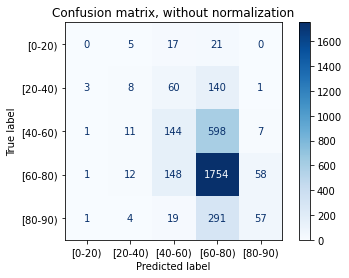

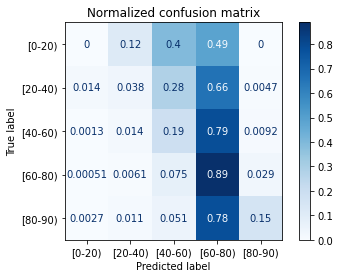

In [65]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(model, X_test, y_test,
                                 display_labels=["[0-20)", "[20-40)", "[40-60)", "[60-80)", "[80-90)"],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

## RandomForestClassifier

In [66]:
model_RandomForest = RandomForestClassifier(max_depth=10).fit(X_train, y_train)
y_pred_train = model_RandomForest.predict(X_train)
y_pred_test = model_RandomForest.predict(X_test)

print('Precisión en entrenamiento', accuracy_score(y_train, y_pred_train))
print('Precisión en test', accuracy_score(y_test, y_pred_test))

Precisión en entrenamiento 0.6065655062977289
Precisión en test 0.5900029753049688


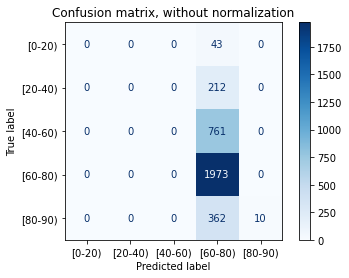

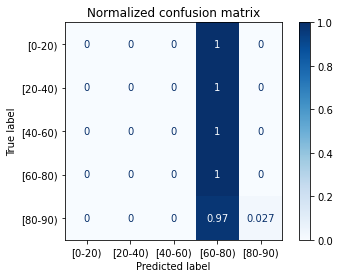

In [67]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(model_RandomForest, X_test, y_test,
                                 display_labels=["[0-20)", "[20-40)", "[40-60)", "[60-80)", "[80-90)"],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

# Second model

In [68]:
vif_prueba = vif_table.drop(vif_table["VIF Factor"][vif_table["VIF Factor"] > 2.5].index)

In [69]:
modelo_keep = dataAux[vif_prueba["features"]]
X = modelo_keep
y = dataAux["Rating"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

## LinearRegression

In [70]:
lm.fit(X_train, y_train)
predictions_train = lm.predict(X_train)
predictions_test = lm.predict(X_test)

In [71]:
mean_absolute_error(predictions_train, y_train)

9.39121098005591

In [72]:
np.sqrt(mean_squared_error(predictions_train, y_train))

12.774093175897471

In [73]:
mean_absolute_error(predictions_test, y_test)

50583435171568.09

In [74]:
np.sqrt(mean_squared_error(predictions_test, y_test))

990038919532192.0

In [75]:
r2_score(predictions_train, y_train)

-1.5671779215968198

In [76]:
r2_score(predictions_test, y_test)

-0.0004379152533282582

## Decision tree

In [77]:
y = dataAux_tree
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [78]:
model = DecisionTreeClassifier(max_depth=10).fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print('Precisión en entrenamiento', accuracy_score(y_train, y_pred_train))
print('Precisión en test', accuracy_score(y_test, y_pred_test))

Precisión en entrenamiento 0.661211940890608
Precisión en test 0.6087473966081524


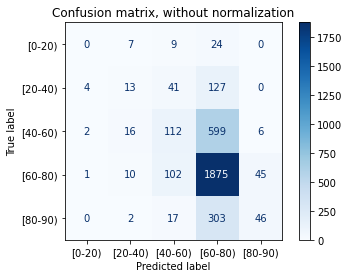

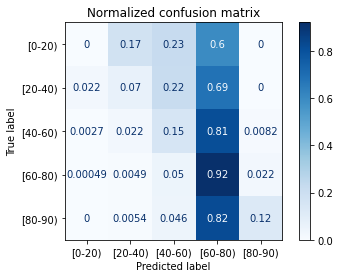

In [79]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(model, X_test, y_test,
                                 display_labels=["[0-20)", "[20-40)", "[40-60)", "[60-80)", "[80-90)"],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

## RandomForestClassifier

In [80]:
model_RandomForest = RandomForestClassifier(max_depth=10).fit(X_train, y_train)
y_pred_train = model_RandomForest.predict(X_train)
y_pred_test = model_RandomForest.predict(X_test)

print('Precisión en entrenamiento', accuracy_score(y_train, y_pred_train))
print('Precisión en test', accuracy_score(y_test, y_pred_test))

Precisión en entrenamiento 0.6001190121987504
Precisión en test 0.6060696221362689


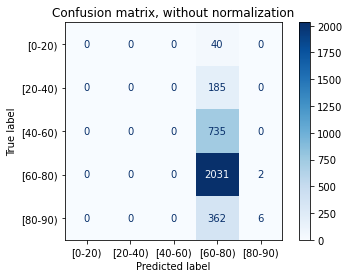

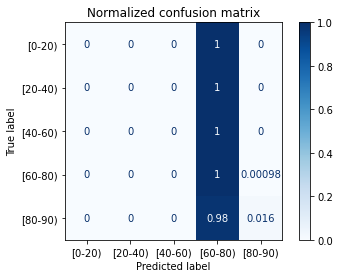

In [81]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(model_RandomForest, X_test, y_test,
                                 display_labels=["[0-20)", "[20-40)", "[40-60)", "[60-80)", "[80-90)"],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

# Data visualization 

## Boxplot representation

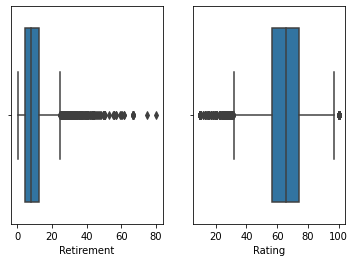

In [82]:
fig, (ax1, ax2) = plt.subplots(1,2)
sns.boxplot(x=dataAux["Retirement"], ax=ax1)
sns.boxplot(x=dataAux["Rating"], ax=ax2)

fig.savefig("images/retirement_rating_boxPlot.png", dpi = 300, bbox_inches='tight')



## Average SinglePlayer representation

Single players Main Story Na:  1780


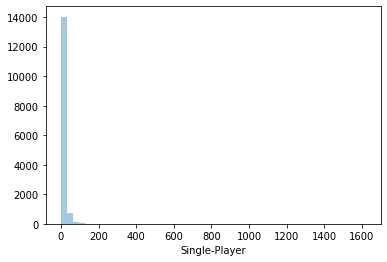

In [83]:
#Esta funcion pone en na todos los que no tienen Main Story, (ya sea porque no tienen o porque es main + extras)

spAverage = dataAns1["Single-Player"].apply(lambda x: get_mainStory(x)).dropna()#Promedios
print("Single players Main Story Na: ", dataAns1["Single-Player"].shape[0] - spAverage.shape[0])
sns.distplot(spAverage, kde= False);

In [84]:
pd.DataFrame(spAverage.describe()).transpose()

,count,mean,std,min,25%,50%,75%,max
Single-Player,14955.0,10.750388,27.601031,0.0,2.3,5.55,11.625,1617.466667


## SinglePlayer representation delimited

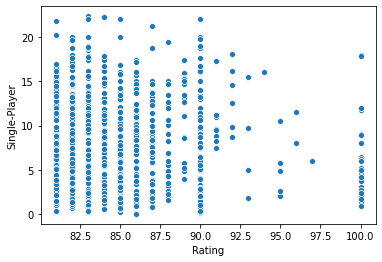

In [85]:
spMainStory = dataAns1["Single-Player"].apply(lambda x: get_mainStory(x))
sns.scatterplot(rating[(rating > 80) & (spMainStory < 150)], spMainStory[(rating > 80) & (spMainStory < 150)]);

## Top Platforms visualization delimited

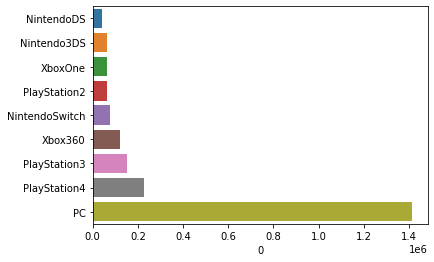

In [86]:
topPlatforms = pd.DataFrame(gameNTotal, games)[0][pd.DataFrame(gameNTotal, games)[0] > np.mean(gameNTotal)]
topPlatforms = topPlatforms.sort_values()
sns.barplot(topPlatforms, topPlatforms.index);

In [87]:
topPlatforms

NintendoDS          42180.0
Nintendo3DS         62628.0
XboxOne             63504.0
PlayStation2        64969.0
NintendoSwitch      74907.0
Xbox360            120785.0
PlayStation3       149800.0
PlayStation4       225898.0
PC                1410922.0
Name: 0, dtype: float64

## NA/JP/EU vs Rating

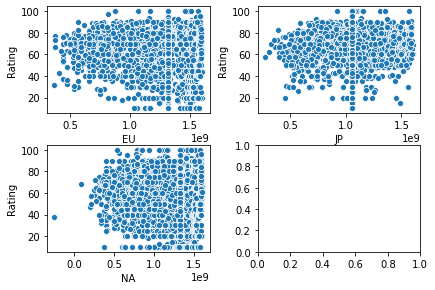

In [88]:
launchLocation = ["EU", "JP", "NA"]

rating = dataAux["Rating"]


fig, ax = plt.subplots(2,2)
fig.tight_layout()

sns.scatterplot(dataAux["EU"], rating , ax = ax[0, 0]);
sns.scatterplot(dataAux["JP"], rating , ax = ax[0, 1]);
sns.scatterplot(dataAux["NA"], rating , ax = ax[1, 0]);

if not dataAux_outliers.empty:
    fig.savefig("images/launch_dates1_scatterplot.png", dpi = 300, bbox_inches='tight')

    rating = dataAux_outliers["Rating"]

    fig, ax = plt.subplots(2,2)
    fig.tight_layout()

    sns.scatterplot(dataAux_outliers["EU"], rating , ax = ax[0, 0]);
    sns.scatterplot(dataAux_outliers["JP"], rating , ax = ax[0, 1]);
    sns.scatterplot(dataAux_outliers["NA"], rating , ax = ax[1, 0]);

    fig.savefig("images/launch_dates2_scatterplot.png", dpi = 300, bbox_inches='tight')


## Top Publishers count and Publishers by rating

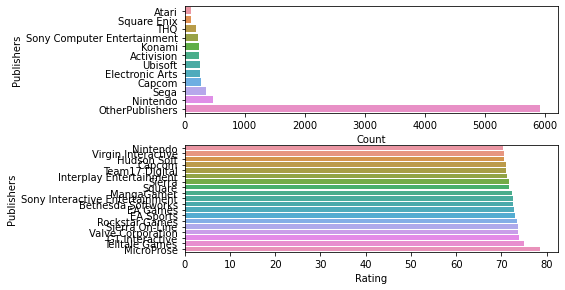

In [89]:
publishers_count=dataAns2.groupby(["Publishers"])["Publishers"].count().sort_values()
topPublishers = pd.DataFrame(publishers_count.values, publishers_count.index)

topPublishersAux = topPublishers[topPublishers[0] > 100]

fig, (ax1, ax2) = plt.subplots(2,1)
fig.tight_layout()

sns.barplot(topPublishersAux[0].values, topPublishersAux.index.values, ax= ax1)
ax1.set(xlabel='Count', ylabel='Publishers')

publishers_by_rating = dataAns2[["Publishers", "Rating"]].groupby(["Publishers"]).mean().sort_values(by=["Rating"])

sns.barplot(publishers_by_rating.Rating[publishers_by_rating.Rating > 70].values, publishers_by_rating.Rating[publishers_by_rating.Rating > 70].index, ax= ax2)
ax2.set(xlabel='Rating', ylabel='Publishers');

fig.savefig("images/publishers_data1_barplot.png", dpi = 300, bbox_inches='tight')


In [90]:
topPublishersAux

,0
Publishers,
Atari,105
Square Enix,109
THQ,184
Sony Computer Entertainment,219
Konami,231
Activision,235
Ubisoft,252
Electronic Arts,258
Capcom,276


In [91]:
pd.DataFrame(publishers_by_rating.Rating[publishers_by_rating.Rating > 70])

,Rating
Publishers,
Nintendo,70.446316
Virgin Interactive,70.500000
Hudson Soft,70.674419
Capcom,70.971014
Team17 Digital,71.083333
Interplay Entertainment,71.150000
Sierra,71.600000
Square,71.714286
MangaGamer,72.400000


In [92]:
if not dataAns2_outliers.empty:
    publishers_count=dataAns2_outliers.groupby(["Publishers"])["Publishers"].count().sort_values()
    topPublishers = pd.DataFrame(publishers_count.values, publishers_count.index)

    topPublishersAux = topPublishers[topPublishers[0] > 100]

    fig, (ax1, ax2) = plt.subplots(2,1)
    fig.tight_layout()

    sns.barplot(topPublishersAux[0].values, topPublishersAux.index.values, ax= ax1)
    ax1.set(xlabel='Count', ylabel='Publishers')

    publishers_by_rating = dataAns2_outliers[["Publishers", "Rating"]].groupby(["Publishers"]).mean().sort_values(by=["Rating"])

    sns.barplot(publishers_by_rating.Rating[publishers_by_rating.Rating > 70].values, publishers_by_rating.Rating[publishers_by_rating.Rating > 70].index, ax= ax2)
    ax2.set(xlabel='Rating', ylabel='Publishers');

    fig.savefig("images/publishers_data2_barplot.png", dpi = 300, bbox_inches='tight')

In [93]:
if not dataAns2_outliers.empty:
    topPublishersAux

In [94]:
if not dataAns2_outliers.empty:
    pd.DataFrame(publishers_by_rating.Rating[publishers_by_rating.Rating > 70])

## Top Developers count and Developers by rating

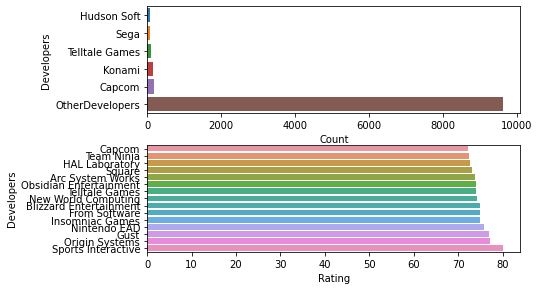

In [95]:
developers_count=dataAns2.groupby(["Developers"])["Developers"].count().sort_values()
topDevelopers = pd.DataFrame(developers_count.values, developers_count.index)

topDevelopersAux = topDevelopers[topDevelopers[0] > 60]

fig, (ax1, ax2) = plt.subplots(2,1)
fig.tight_layout()

sns.barplot(topDevelopersAux[0], topDevelopersAux.index, ax=ax1)
ax1.set(xlabel='Count', ylabel='Developers');

developers_by_rating = dataAns2[["Developers", "Rating"]].groupby(["Developers"]).mean().sort_values(by=["Rating"])

sns.barplot(developers_by_rating.Rating[developers_by_rating.Rating > 72].values, developers_by_rating.Rating[developers_by_rating.Rating > 72].index, ax= ax2)
ax2.set(xlabel='Rating', ylabel='Developers');

fig.savefig("images/developers_data1_barplot.png", dpi = 300, bbox_inches='tight')


In [96]:
topDevelopersAux

,0
Developers,
Hudson Soft,63
Sega,73
Telltale Games,111
Konami,152
Capcom,179
OtherDevelopers,9620


In [97]:
developers_by_rating.Rating[developers_by_rating.Rating > 72]

Developers
Capcom                    72.189944
Team Ninja                72.388889
HAL Laboratory            72.741935
Square                    73.000000
Arc System Works          73.750000
Obsidian Entertainment    74.100000
Telltale Games            74.108108
New World Computing       74.222222
Blizzard Entertainment    74.857143
From Software             74.968750
Insomniac Games           75.000000
Nintendo EAD              75.709091
Gust                      77.000000
Origin Systems            77.071429
Sports Interactive        80.000000
Name: Rating, dtype: float64

In [98]:
if not dataAns2_outliers.empty:
    developers_count=dataAns2_outliers.groupby(["Developers"])["Developers"].count().sort_values()
    topDevelopers = pd.DataFrame(developers_count.values, developers_count.index)

    topDevelopersAux = topDevelopers[topDevelopers[0] > 60]

    fig, (ax1, ax2) = plt.subplots(2,1)
    fig.tight_layout()

    sns.barplot(topDevelopersAux[0], topDevelopersAux.index, ax=ax1)
    ax1.set(xlabel='Count', ylabel='Developers');

    developers_by_rating = dataAns2_outliers[["Developers", "Rating"]].groupby(["Developers"]).mean().sort_values(by=["Rating"])

    sns.barplot(developers_by_rating.Rating[developers_by_rating.Rating > 72].values, developers_by_rating.Rating[developers_by_rating.Rating > 72].index, ax= ax2)
    ax2.set(xlabel='Rating', ylabel='Developers');

    fig.savefig("images/developers_data2_barplot.png", dpi = 300, bbox_inches='tight')

In [99]:
if not dataAns2_outliers.empty:
    topDevelopersAux

In [100]:
if not dataAns2_outliers.empty:
    developers_by_rating.Rating[developers_by_rating.Rating > 72]

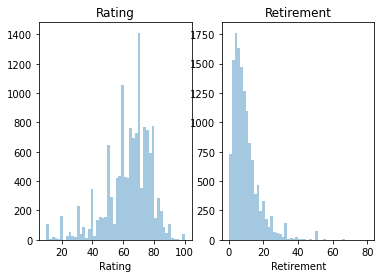

In [101]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("Rating")
sns.distplot(dataAns2["Rating"], kde= False, ax = ax1)
ax2.set_title("Retirement")
sns.distplot(dataAns2["Retirement"], kde= False,ax = ax2)
plt.show()

## Main Story/Main+Extras/Completionist/AllPlayStyles vs Rating

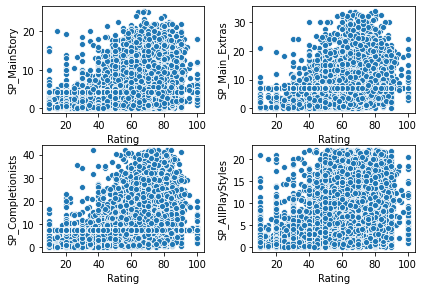

In [102]:
spType = ["SP_MainStory", "SP_Main_Extras", "SP_Completionists", "SP_AllPlayStyles"]

rating = dataAux["Rating"]

fig, ax = plt.subplots(2,2)
fig.tight_layout()

spTime = dataAux["SP_MainStory"].apply(lambda x: get_storyAnalisisFormatted(x))
sns.scatterplot(rating, spTime, ax = ax[0,0]);  

spTime = dataAux["SP_Main_Extras"].apply(lambda x: get_storyAnalisisFormatted(x))
sns.scatterplot(rating, spTime, ax = ax[0,1]);  

spTime = dataAux["SP_Completionists"].apply(lambda x: get_storyAnalisisFormatted(x))
sns.scatterplot(rating, spTime, ax = ax[1,0]);  

spTime = dataAux["SP_AllPlayStyles"].apply(lambda x: get_storyAnalisisFormatted(x))
sns.scatterplot(rating, spTime, ax = ax[1,1]);  

fig.savefig("images/time_vs_rating1_scatterplot.png", dpi = 300, bbox_inches='tight')


In [103]:
spType = ["SP_MainStory", "SP_Main_Extras", "SP_Completionists", "SP_AllPlayStyles"]

if not dataAux_outliers.empty:

    rating = dataAux_outliers["Rating"]

    fig, ax = plt.subplots(2,2)
    fig.tight_layout()

    spTime = dataAux_outliers["SP_MainStory"].apply(lambda x: get_storyAnalisisFormatted(x))
    sns.scatterplot(rating, spTime, ax = ax[0,0]);  

    spTime = dataAux_outliers["SP_Main_Extras"].apply(lambda x: get_storyAnalisisFormatted(x))
    sns.scatterplot(rating, spTime, ax = ax[0,1]);  

    spTime = dataAux_outliers["SP_Completionists"].apply(lambda x: get_storyAnalisisFormatted(x))
    sns.scatterplot(rating, spTime, ax = ax[1,0]);  

    spTime = dataAux_outliers["SP_AllPlayStyles"].apply(lambda x: get_storyAnalisisFormatted(x))
    sns.scatterplot(rating, spTime, ax = ax[1,1]);  

    fig.savefig("images/time_vs_rating2_scatterplot.png", dpi = 300, bbox_inches='tight')

## Top Genres by count

In [104]:
def get_ratings_from_column(row, column_dict):
    for key in column_dict.keys():
        if row[key] == 1:
            column_dict[key] = column_dict[key] + 1
    return column_dict

In [105]:
def get_string_from_match(x, regex_match):
    try:
        return regex_match.search(x).string
    except Exception as e:
        return None

In [106]:
def substitute_genres_values_by_rating(column, rating_column):
    for index, row in column.iteritems():
        if row == 1.0:
            column[index] = rating_column[index]
            
    return column
    

In [107]:
r_genres = re.compile('^G\_.*')
findGenCols = np.vectorize(lambda x:bool(r_genres.search(x)))

cols_bool = findGenCols(dataAns2.columns.values)
data_genres = dataAns2[dataAns2.columns[cols_bool]]

In [108]:
findGenCols = np.vectorize(lambda x:get_string_from_match(x,r_genres))
match_genres = findGenCols(dataAns2.columns.values)

#Delete None variables
match_genres = match_genres[match_genres != np.array(None)]


genres_dict = {k: 0 for k in match_genres}


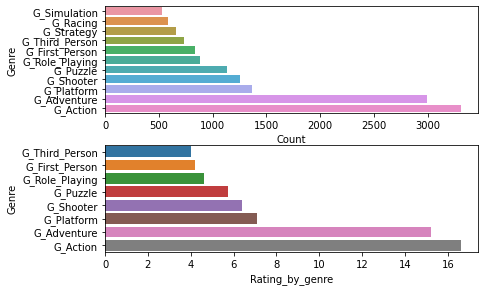

In [109]:
genres_sums = data_genres.sum(axis=0).sort_values()

fig, (ax1, ax2) = plt.subplots(2,1)
fig.tight_layout()

sns.barplot(genres_sums[genres_sums.values >500].values, genres_sums[genres_sums.values >500].index, ax=ax1)
ax1.set(xlabel='Count', ylabel='Genre');

dataAns2_genres = dataAns2.copy()
dataAns2_genres[match_genres] = dataAns2_genres[match_genres].apply(lambda x: substitute_genres_values_by_rating(x, dataAns2_genres['Rating']))
dataAns2_melted_genre = pd.melt(dataAns2_genres, id_vars=['Rating'],var_name='Genre', value_name='Rating_by_genre', value_vars=match_genres)
dataAns2_melted_genre = dataAns2_melted_genre[["Genre", "Rating_by_genre"]].groupby(["Genre"]).mean().sort_values(by=["Rating_by_genre"])

sns.barplot(dataAns2_melted_genre[dataAns2_melted_genre["Rating_by_genre"]> 4].Rating_by_genre.values,
                 dataAns2_melted_genre[dataAns2_melted_genre["Rating_by_genre"]> 4].index, ax=ax2)
ax2.set(xlabel='Rating_by_genre', ylabel='Genre'); 

fig.savefig("images/genres_data1_barplot.png", dpi = 300, bbox_inches='tight')

In [110]:
pd.DataFrame(genres_sums[genres_sums.values >500])

,0
G_Simulation,529.0
G_Racing,582.0
G_Strategy,655.0
G_Third_Person,731.0
G_First_Person,833.0
G_Role_Playing,884.0
G_Puzzle,1130.0
G_Shooter,1250.0
G_Platform,1367.0
G_Adventure,2995.0


In [111]:
dataAns2_melted_genre[dataAns2_melted_genre["Rating_by_genre"]> 4]

,Rating_by_genre
Genre,
G_Third_Person,4.002620
G_First_Person,4.218147
G_Role_Playing,4.598555
G_Puzzle,5.727792
G_Shooter,6.405017
G_Platform,7.098119
G_Adventure,15.195920
G_Action,16.588235


In [112]:
r_genres = re.compile('^G\_.*')
findGenCols = np.vectorize(lambda x:bool(r_genres.search(x)))

cols_bool = findGenCols(dataAns2_outliers.columns.values)
data_genres = dataAns2_outliers[dataAns2_outliers.columns[cols_bool]]

In [113]:
findGenCols = np.vectorize(lambda x:get_string_from_match(x,r_genres))
match_genres = findGenCols(dataAns2_outliers.columns.values)

#Delete None variables
match_genres = match_genres[match_genres != np.array(None)]


genres_dict = {k: 0 for k in match_genres}


In [114]:
if not dataAns2_outliers.empty:
    genres_sums_outlier = data_genres.sum(axis=0).sort_values()

    fig, (ax1, ax2) = plt.subplots(2,1)
    fig.tight_layout()


    sns.barplot(genres_sums_outlier[genres_sums_outlier.values >500].values, genres_sums_outlier[genres_sums_outlier.values >500].index, ax=ax1)
    ax1.set(xlabel='Count', ylabel='Genre');

    dataAns2_genres = dataAns2_outliers.copy()
    dataAns2_genres[match_genres] = dataAns2_genres[match_genres].apply(lambda x: substitute_genres_values_by_rating(x, dataAns2_genres['Rating']))
    dataAns2_melted_genre_out = pd.melt(dataAns2_genres, id_vars=['Rating'],var_name='Genre', value_name='Rating_by_genre', value_vars=match_genres)
    dataAns2_melted_genre_out = dataAns2_melted_genre_out[["Genre", "Rating_by_genre"]].groupby(["Genre"]).mean().sort_values(by=["Rating_by_genre"])

    sns.barplot(dataAns2_melted_genre_out[dataAns2_melted_genre_out["Rating_by_genre"]> 4].Rating_by_genre.values,
                     dataAns2_melted_genre_out[dataAns2_melted_genre_out["Rating_by_genre"]> 4].index, ax=ax2)
    ax2.set(xlabel='Rating_by_genre', ylabel='Genre'); 

    fig.savefig("images/genres_data2_barplot.png", dpi = 300, bbox_inches='tight')

In [115]:
if not dataAns2_outliers.empty:
    pd.DataFrame(genres_sums_outlier[genres_sums_outlier.values >500])

In [116]:
if not dataAns2_outliers.empty:
    dataAns2_melted_genre_out[dataAns2_melted_genre_out["Rating_by_genre"]> 4]

## Top Platform N by count and rating

In [117]:
def substitute_platform_values_by_rating(column, rating_column):
    for index, row in column.iteritems():
        if row != 0.0:
            column[index] = rating_column[index]
            
    return column

In [118]:
r_nums = re.compile('^N\_.*')
findNumsCols = np.vectorize(lambda x:bool(r_nums.search(x)))

cols_bool = findNumsCols(dataAns2.columns.values)
data_num_platforms = dataAns2[dataAns2.columns[cols_bool]]

In [119]:
findNumCols = np.vectorize(lambda x:get_string_from_match(x,r_nums))
match_platforms = findNumCols(dataAns2.columns.values)

#Delete None variables
match_platforms = match_platforms[match_platforms != np.array(None)]


platforms_dict = {k: 0 for k in match_platforms}

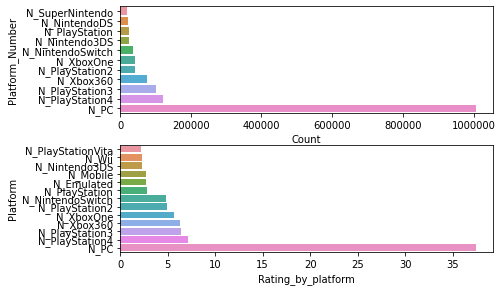

In [120]:
n_platform_sums = data_num_platforms.sum(axis=0).sort_values().astype(int)

fig, (ax1, ax2) = plt.subplots(2,1)
fig.tight_layout()

sns.barplot(n_platform_sums[n_platform_sums.values > 20000].values, n_platform_sums[n_platform_sums.values > 20000].index, ax=ax1)
ax1.get_xaxis().get_major_formatter().set_scientific(False)
ax1.set(xlabel='Count', ylabel='Platform_Number');

dataAns2_platform = dataAns2.copy()
dataAns2_platform[match_platforms] = dataAns2_platform[match_platforms].apply(lambda x: substitute_platform_values_by_rating(x, dataAns2_platform['Rating']))
dataAns2_melted_platform = pd.melt(dataAns2_platform, id_vars=['Rating'],var_name='Platform', value_name='Rating_by_platform', value_vars=match_platforms)
dataAns2_melted_platform = dataAns2_melted_platform[["Platform", "Rating_by_platform"]].groupby(["Platform"]).mean().sort_values(by=["Rating_by_platform"])

sns.barplot(dataAns2_melted_platform[dataAns2_melted_platform["Rating_by_platform"]>2].Rating_by_platform.values,
                 dataAns2_melted_platform[dataAns2_melted_platform["Rating_by_platform"]>2].index, ax=ax2)
ax2.set(xlabel='Rating_by_platform', ylabel='Platform');

fig.savefig("images/platform_data1_barplot.png", dpi = 300, bbox_inches='tight') 

In [121]:
pd.DataFrame(n_platform_sums[n_platform_sums.values > 20000])

,0
N_SuperNintendo,20254
N_NintendoDS,22399
N_PlayStation,25922
N_Nintendo3DS,26170
N_NintendoSwitch,35553
N_XboxOne,41868
N_PlayStation2,43336
N_Xbox360,75528
N_PlayStation3,100509
N_PlayStation4,120815


In [122]:
dataAns2_melted_platform[dataAns2_melted_platform["Rating_by_platform"]>2]

,Rating_by_platform
Platform,
N_PlayStationVita,2.221586
N_Wii,2.315457
N_Nintendo3DS,2.316275
N_Mobile,2.721586
N_Emulated,2.763761
N_PlayStation,2.828102
N_NintendoSwitch,4.821779
N_PlayStation2,4.898393
N_XboxOne,5.713627


In [123]:
r_nums = re.compile('^N\_.*')
findNumsCols = np.vectorize(lambda x:bool(r_nums.search(x)))

cols_bool = findNumsCols(dataAns2_outliers.columns.values)
data_num_platforms = dataAns2_outliers[dataAns2_outliers.columns[cols_bool]]

In [124]:
findNumCols = np.vectorize(lambda x:get_string_from_match(x,r_nums))
match_platforms = findNumCols(dataAns2.columns.values)

#Delete None variables
match_platforms = match_platforms[match_platforms != np.array(None)]


platforms_dict = {k: 0 for k in match_platforms}

In [125]:
if not dataAns2_outliers.empty:
    n_platform_sums_outlier = data_num_platforms.mean(axis=0).sort_values().astype(int)

    fig, (ax1, ax2) = plt.subplots(2,1)
    fig.tight_layout()

    sns.barplot(n_platform_sums_outlier[n_platform_sums_outlier.values > 50].values, n_platform_sums_outlier[n_platform_sums_outlier.values > 50].index, ax=ax1)
    ax1.get_xaxis().get_major_formatter().set_scientific(False)
    ax1.set(xlabel='Count', ylabel='Platform_Number');

    dataAns2_platform = dataAns2_outliers.copy()
    dataAns2_platform[match_platforms] = dataAns2_platform[match_platforms].apply(lambda x: substitute_platform_values_by_rating(x, dataAns2_platform['Rating']))
    dataAns2_melted_platform_out = pd.melt(dataAns2_platform, id_vars=['Rating'],var_name='Platform', value_name='Rating_by_platform', value_vars=match_platforms)
    dataAns2_melted_platform_out = dataAns2_melted_platform_out[["Platform", "Rating_by_platform"]].groupby(["Platform"]).mean().sort_values(by=["Rating_by_platform"])

    sns.barplot(dataAns2_melted_platform_out[dataAns2_melted_platform_out["Rating_by_platform"]> 4].Rating_by_platform.values,
                     dataAns2_melted_platform_out[dataAns2_melted_platform_out["Rating_by_platform"]> 4].index, ax=ax2)
    ax2.set(xlabel='Rating_by_platform', ylabel='Platform');

    fig.savefig("images/platform_data2_barplot.png", dpi = 300, bbox_inches='tight') 

In [126]:
if not dataAns2_outliers.empty:
    pd.DataFrame(n_platform_sums_outlier[n_platform_sums_outlier.values > 20000])

In [127]:
if not dataAns2_outliers.empty:
    dataAns2_melted_platform_out[dataAns2_melted_platform_out["Rating_by_platform"]>2]

## Rating vs SP-Main Story vs (Developers/Publishers)

In [128]:
developers_by_rating = dataAns2[["Developers", "Rating"]].groupby(["Developers"]).sum().sort_values(by=["Rating"])
top_developers_by_rating = pd.DataFrame(developers_by_rating.values, developers_by_rating.index)

top_developers_by_ratingAux = top_developers_by_rating[top_developers_by_rating[0] > 2500]

In [129]:
spMainStory = dataAns2["SP_MainStory"].apply(lambda x: get_storyAnalisisFormatted(x))
rating = dataAns2["Rating"]

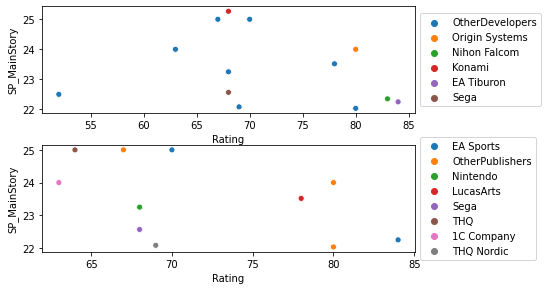

In [130]:
developers = dataAns2["Developers"]

fig, (ax1, ax2) = plt.subplots(2,1)
fig.tight_layout()

sns.scatterplot(rating[spMainStory > 22], spMainStory[spMainStory > 22]
                , hue=developers[spMainStory > 22].values, ax=ax1)

ax1.legend(loc='center left',bbox_to_anchor=(1, 0.5));

publishers = dataAns2["Publishers"]

sns.scatterplot(rating[spMainStory > 22], spMainStory[spMainStory > 22],
                hue=publishers[spMainStory > 22].values, ax=ax2)

ax2.legend(loc='center left',bbox_to_anchor=(1, 0.5));

fig.savefig("images/timeVSratingVSpub_dev1_scatterplot.png", dpi = 300, bbox_inches='tight')

In [131]:
spMainStory = dataAns2_outliers["SP_MainStory"].apply(lambda x: get_storyAnalisisFormatted(x))
rating = dataAns2_outliers["Rating"]

In [132]:
if not dataAns2_outliers.empty:
    developers = dataAns2_outliers["Developers"]

    fig, (ax1, ax2) = plt.subplots(2,1)
    fig.tight_layout()

    sns.scatterplot(rating, spMainStory, hue=developers.values, ax=ax1)

    ax1.legend(loc='center left',bbox_to_anchor=(1, 0.5));

    publishers = dataAns2_outliers["Publishers"]

    sns.scatterplot(rating, spMainStory, hue=publishers.values, ax=ax2)

    ax2.legend(loc='center left',bbox_to_anchor=(1, 0.5));

    fig.savefig("images/timeVSratingVSpub_dev2_scatterplot.png", dpi = 300, bbox_inches='tight')